In [91]:
!git clone https://github.com/daniarnaizg/text-detector-ocr.git

fatal: destination path 'text-detector-ocr' already exists and is not an empty directory.


In [92]:
!ls

A.jpg	 datalab  D.jpg    EnglishImg.tgz  R2.jpg  Rodney.jpg	      U.jpg
cropped  dataset  English  O.jpg	   R.jpg   text-detector-ocr


In [0]:
# from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D
# from keras.layers import Flatten, Lambda, BatchNormalization
from keras.models import Sequential
# from keras.layers.advanced_activations import LeakyReLU
# from keras.preprocessing.image import ImageDataGenerator
# from keras.optimizers import Adam


# initialize the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model_path = 'text-detector-ocr/Models/text-notext.h5'
model.load_weights(model_path)

In [0]:
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array

def get_prediction(image):
#   image = cv2.imread(image)
  orig = image.copy()

  # pre-process the image for classification
  image = cv2.resize(image, (28, 28))
  image = image.astype("float") / 255.0
  image = img_to_array(image)
  image = np.expand_dims(image, axis=0)
  
  (notext, text) = model.predict(image)[0]
  pred = True if text > notext else False

  return pred

In [0]:
def pyramid(image, scale=1.5, minSize=(30, 30)):
	yield image
 
	# keep looping over the pyramid
	while True:
		# compute the new dimensions of the image and resize it
		w = int(image.shape[1] / scale)
		image = cv2.resize(image, (w,w)) #imutils.resize(image, width=w)
 
		# if the resized image does not meet the supplied minimum
		# size, then stop constructing the pyramid
		if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
			break
 
		# yield the next image in the pyramid
		yield image

In [0]:
def sliding_window(image, stepSize, windowSize):
	# slide a window across the image
	for y in xrange(0, image.shape[0], stepSize):
		for x in xrange(0, image.shape[1], stepSize):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [0]:
from matplotlib import pyplot as plt
import cv2
import os
import time

def slide_predict(file_name):
#   new_dir = 'cropped/' + file_name[:-4] + '/'
#   print(new_dir)
#   if not os.path.exists(new_dir):
#     os.makedirs(new_dir)

  image = cv2.imread(file_name)
  (W, H) = (28, 28)
  
  orig = image.copy()
  
#   count = 0
#   for resized in pyramid(image, scale=1.5):
  for (x, y, window) in sliding_window(orig, stepSize=32, windowSize=(W, H)):
    if window.shape[0] != H or window.shape[1] != W:
  		continue
      
    cropped = orig[y:y+H, x:x+W]
    text = get_prediction(cropped)
      
    if text:
      cv2.rectangle(image, (x, y), (x + W, y + H), (0, 255, 0), 2)
#       cv2.imwrite( new_dir + str(count) + '.jpg' , cropped)
#       count = count + 1
        
  plt.imshow(image)
  plt.axis('off')
  plt.show()      
  
#   return count

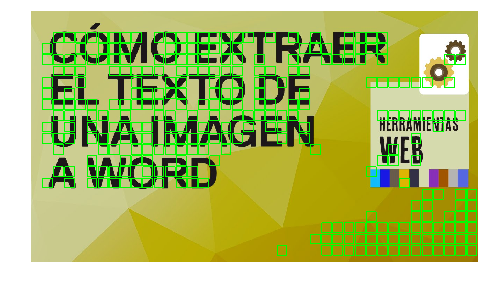

In [221]:
slide_predict('5.jpg')